In [2]:
!pip install shap

   ---------------------------------------- 0.0/489.8 kB ? eta -:--:--
   -- ------------------------------------- 30.7/489.8 kB 1.3 MB/s eta 0:00:01
   ------------------ --------------------- 225.3/489.8 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------  481.3/489.8 kB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 489.8/489.8 kB 3.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
from itertools import product

from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_curve, roc_auc_score, make_scorer, f1_score, recall_score
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, VotingClassifier, StackingClassifier
)
import xgboost as xgb
import lightgbm as lgb

from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split


In [4]:
train_df_oversampled = pd.read_csv("data/oversampled_data_with_rfecv/train_oversampled.csv")
test_df_oversampled = pd.read_csv("data/oversampled_data_with_rfecv/test.csv")
X_train_oversampled = train_df_oversampled.drop(['FraudFound_P'],axis=1)
y_train_oversampled = train_df_oversampled['FraudFound_P']
X_test = test_df_oversampled.drop(['FraudFound_P'],axis=1)
y_test = test_df_oversampled['FraudFound_P']

## Logistic Regression without tuning

In [35]:
# Train logistic regression model
lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train_oversampled, y_train_oversampled)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)
classification_rep = classification_report(y_test, y_pred_lr)
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_lr))

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)

ROC AUC on validation: 0.6502904470358726
Accuracy: 0.6521
Confusion Matrix:
[[1882 1003]
 [  70  129]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.65      0.78      2885
           1       0.11      0.65      0.19       199

    accuracy                           0.65      3084
   macro avg       0.54      0.65      0.49      3084
weighted avg       0.91      0.65      0.74      3084



C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Hyperparameter tuning of Logistic Regression Model

In [36]:
# logistic regression algo
lr_model = LogisticRegression(verbose=0,random_state=42)

# Define parameter grid
param_dict_lr = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000],
}


# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up RandomizedSearchCV
search_lr = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=param_dict_lr,
    n_iter=20,  # try more for better results
    scoring='roc_auc',
    n_jobs=1,
    cv=cv,
    verbose=2,
    random_state=42
)

# Fit the search
search_lr.fit(X_train_oversampled, y_train_oversampled)

# Best params and score
print("Best Parameters:", search_lr.best_params_)
print("Best ROC AUC:", search_lr.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1000, penalty=l2, solver=saga; total time=   5.3s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1000, penalty=l2, solver=saga; total time=   5.4s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=100, max_iter=1000, penalty=l2, solver=saga; total time=   5.7s
[CV] END C=1, max_iter=1000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=1, max_iter=1000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=1, max_iter=1000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ..C=100, max_iter=500, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..C=100, max_iter=500, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..C=100, max_iter=500, penalty=l2, solver=liblinear; total time=   0.1s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=10, max_iter=500, penalty=l2, solver=saga; total time=   2.6s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=10, max_iter=500, penalty=l2, solver=saga; total time=   2.8s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=10, max_iter=500, penalty=l2, solver=saga; total time=   3.3s
[CV] END ....C=1, max_iter=500, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ....C=1, max_iter=500, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ....C=1, max_iter=500, penalty=l2, solver=liblinear; total time=   0.1s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........C=1, max_iter=500, penalty=l2, solver=saga; total time=   3.3s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........C=1, max_iter=500, penalty=l2, solver=saga; total time=   2.4s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........C=1, max_iter=500, penalty=l2, solver=saga; total time=   2.3s
[CV] END C=100, max_iter=1000, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=100, max_iter=1000, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=100, max_iter=1000, penalty=elasticnet, solver=liblinear; total time=   0.0s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=500, penalty=l2, solver=saga; total time=   2.7s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=500, penalty=l2, solver=saga; total time=   3.0s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=100, max_iter=500, penalty=l2, solver=saga; total time=   2.4s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...C=1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=0.1, max_iter=500, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=0.1, max_iter=500, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=0.1, max_iter=500, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .C=0.1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.1, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=10, max_iter=500, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...C=10, max_iter=500, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ...C=10, max_iter=5

C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=0.1, max_iter=1000, penalty=l2, solver=saga; total time=   4.9s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=0.1, max_iter=1000, penalty=l2, solver=saga; total time=   7.8s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......C=0.1, max_iter=1000, penalty=l2, solver=saga; total time=  10.7s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  10.9s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  10.7s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........C=1, max_iter=1000, penalty=l2, solver=saga; total time=  11.1s
[CV] END .C=1, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END .C=1, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END .C=1, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=10, max_iter=1000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=10, max_iter=1000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=10, max_iter=1000, penalty=elasticnet, solver=saga; total time=   0.0s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=0.1, max_iter=500, penalty=l2, solver=saga; total time=   4.1s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......C=0.1, max_iter=500, penalty=l2, solver=saga; total time=   3.4s


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
21 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklea

[CV] END .......C=0.1, max_iter=500, penalty=l2, solver=saga; total time=   3.2s
[CV] END C=0.1, max_iter=500, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.1, max_iter=500, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.1, max_iter=500, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=100, max_iter=500, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=100, max_iter=500, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=100, max_iter=500, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.1, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.1, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.1, max_iter=500, penalty=elasticnet, solver=saga; total time=   0.0s
Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 500, 'C': 100}
Best ROC AUC: 0.8059031899624575


In [37]:
best_model_lr = search_lr.best_estimator_
y_pred_proba = best_model_lr.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.35).astype(int)

# Metrics
from sklearn.metrics import classification_report, roc_auc_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_proba))


[[1645 1240]
 [   7  192]]
              precision    recall  f1-score   support

           0       1.00      0.57      0.73      2885
           1       0.13      0.96      0.24       199

    accuracy                           0.60      3084
   macro avg       0.56      0.77      0.48      3084
weighted avg       0.94      0.60      0.69      3084

ROC AUC on validation: 0.8020640464018532


## RandomForestClassifier Model without tuning

In [38]:
rf_model = RandomForestClassifier(class_weight="balanced", random_state=36)
rf_model.fit(X_train_oversampled, y_train_oversampled)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("==== Random Forest ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_rf))

==== Random Forest ====
Accuracy: 0.9339
Confusion Matrix:
[[2869   16]
 [ 188   11]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2885
           1       0.41      0.06      0.10       199

    accuracy                           0.93      3084
   macro avg       0.67      0.52      0.53      3084
weighted avg       0.90      0.93      0.91      3084

ROC AUC on validation: 0.5248652273499211


## Hyperparameter tuning of RandomForestClassifier model

In [39]:
# Random forest algo
rf_model = RandomForestClassifier(class_weight="balanced", verbose = 0,random_state=42)

# Define parameter grid
param_dict_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 5, 10],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
    'bootstrap': [True, False],  
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up RandomizedSearchCV
search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dict_rf,
    n_iter=20,  # try more for better results
    scoring='roc_auc',
    n_jobs=1,
    cv=cv,
    verbose=2,
    random_state=42
)

# Fit the search
search_rf.fit(X_train_oversampled, y_train_oversampled)

# Best params and score
print("Best Parameters:", search_rf.best_params_)
print("Best ROC AUC:", search_rf.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  10.5s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   8.9s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   8.0s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.9s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.8s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.6s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   6.9s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  10.7s


In [40]:
best_model_rf = search_rf.best_estimator_
y_pred_proba = best_model_rf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.15).astype(int)

# Metrics
from sklearn.metrics import classification_report, roc_auc_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_proba))

[[2409  476]
 [  86  113]]
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      2885
           1       0.19      0.57      0.29       199

    accuracy                           0.82      3084
   macro avg       0.58      0.70      0.59      3084
weighted avg       0.92      0.82      0.86      3084

ROC AUC on validation: 0.8269405955252866


## XGBoost without tuning

In [41]:
xgb_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_oversampled, y_train_oversampled)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("==== XGBoost ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_xgb))

c:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:23:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


==== XGBoost ====
Accuracy: 0.9326
Confusion Matrix:
[[2861   24]
 [ 184   15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2885
           1       0.38      0.08      0.13       199

    accuracy                           0.93      3084
   macro avg       0.66      0.53      0.55      3084
weighted avg       0.90      0.93      0.91      3084

ROC AUC on validation: 0.5335289968037762


## Hyperparameter tuning of XGBoostClassifier

In [42]:
xgb_model = xgb.XGBClassifier(eval_metric="logloss", random_state=42)

# Define parameter grid
param_dict_xgb = {
    'n_estimators': [100, 200], 
    'max_depth': [3, 5, 10, 15], 
    'learning_rate': [0.01, 0.1, 0.2],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],  
    'reg_alpha': [0, 0.01, 0.1], 
    'reg_lambda': [0, 0.01, 0.1], 
    'scale_pos_weight': [1, 5, 10],  
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up RandomizedSearchCV
search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dict_xgb,
    n_iter=20,
    scoring='roc_auc',
    n_jobs=1,
    cv=cv,
    verbose=2,
    random_state=42
)

# Fit the search
search_xgb.fit(X_train_oversampled, y_train_oversampled)

# Best params and score
print("Best Parameters:", search_xgb.best_params_)
print("Best ROC AUC:", search_xgb.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=200, reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=5, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=0.1, scal

In [43]:
best_model_xgb = search_xgb.best_estimator_
y_pred_proba = best_model_xgb.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.025).astype(int)

# Metrics
from sklearn.metrics import classification_report, roc_auc_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_proba))

[[   0 2885]
 [   0  199]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2885
           1       0.06      1.00      0.12       199

    accuracy                           0.06      3084
   macro avg       0.03      0.50      0.06      3084
weighted avg       0.00      0.06      0.01      3084

ROC AUC on validation: 0.8429060379889046


C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

## LightGBM without tuning

In [44]:
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model.fit(X_train_oversampled, y_train_oversampled)
y_pred_lgb = lgb_model.predict(X_test)

# Evaluation
print("==== LightGBM ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))
print("Classification Report:")
print(classification_report(y_test, y_pred_lgb))
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 11611, number of negative: 11611
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4588
[LightGBM] [Info] Number of data points in the train set: 23222, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
==== LightGBM ====
Accuracy: 0.9355
Confusion Matrix:
[[2875   10]
 [ 189   10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2885
           1       0.50      0.05      0.09       199

    accuracy                           0.94      3084
   macro avg       0.72      0.52      0.53      3084
weighted avg       0.91      0.94      0.91      3084

ROC AUC on validation: 0.5233925258876706


## Hyperparameter tuning of LightGBM Model

In [45]:
# Lightgbm algo
lgb_model = lgb.LGBMClassifier(random_state=42, verbose = 0)

# Define parameter grid
param_dict_lgb = {
    'n_estimators': [100, 200],  # Number of boosting rounds
    'max_depth': [3, 5, 10, 15],  # Maximum depth of trees
    'learning_rate': [0.01, 0.1],  # Step size at each iteration
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for training each tree
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used for each tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition
    'reg_alpha': [0, 0.01, 0.1],  # L1 regularization 
    'reg_lambda': [0, 0.01, 0.1],  # L2 regularization
    'scale_pos_weight': [1, 5, 10],  # Controls balance of positive and negative weights
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up RandomizedSearchCV
search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dict_lgb,
    n_iter=20,  # try more for better results
    scoring='roc_auc',
    n_jobs=1,
    cv=cv,
    verbose=2,
    random_state=42
)

# Fit the search
search_lgb.fit(X_train_oversampled, y_train_oversampled)

# Best params and score
print("Best Parameters:", search_lgb.best_params_)
print("Best ROC AUC:", search_lgb.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [46]:
best_model_lgb = search_lgb.best_estimator_
y_pred_proba = best_model_lgb.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.15).astype(int)

# Metrics
from sklearn.metrics import classification_report, roc_auc_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC on validation:", roc_auc_score(y_test, y_pred_proba))

[LightGBM] [Warning] Unknown parameter: gamma
[[2097  788]
 [  27  172]]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      2885
           1       0.18      0.86      0.30       199

    accuracy                           0.74      3084
   macro avg       0.58      0.80      0.57      3084
weighted avg       0.94      0.74      0.80      3084

ROC AUC on validation: 0.8617890143960704


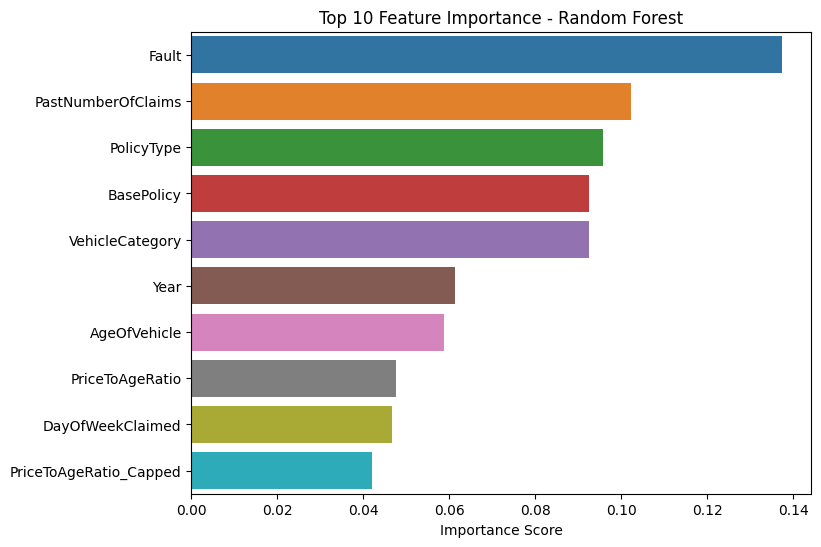

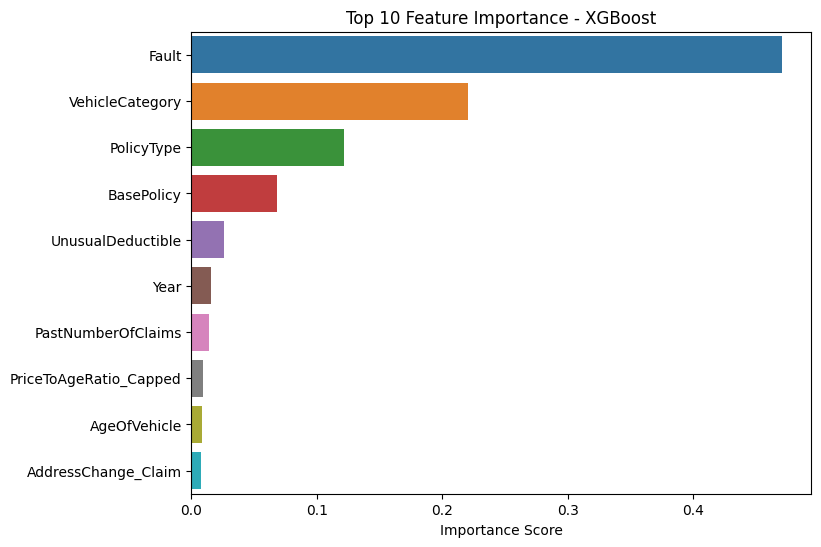

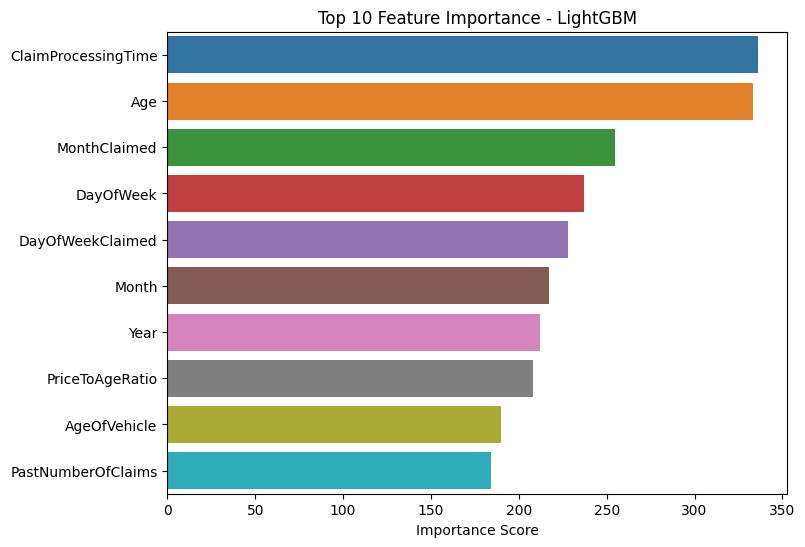

In [52]:
# Feature importance visualization for Random Forest
rf_importances = pd.Series(best_model_rf.feature_importances_, index=X_train_oversampled.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=rf_importances.values[:10], y=rf_importances.index[:10])
plt.title("Top 10 Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.show()

# Feature importance visualization for XGBoost
xgb_importances = pd.Series(best_model_xgb.feature_importances_, index=X_train_oversampled.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=xgb_importances.values[:10], y=xgb_importances.index[:10])
plt.title("Top 10 Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.show()

# Feature importance visualization for LightGBM
lgb_importances = pd.Series(best_model_lgb.feature_importances_, index=X_train_oversampled.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=lgb_importances.values[:10], y=lgb_importances.index[:10])
plt.title("Top 10 Feature Importance - LightGBM")
plt.xlabel("Importance Score")
plt.show()

# Baseline bagging + neural network

In [53]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [54]:
numeric_df = pd.read_csv("data/cleaned_data.csv")
X = numeric_df.drop('FraudFound_P', axis=1)
y = numeric_df['FraudFound_P']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [57]:
# Bagging
def create_bagged_sets(X, y, n=10):
    X_sets, y_sets = [], []
    for _ in range(n):
        idx = np.random.choice(len(X), size=len(X), replace=True)
        X_sets.append(X.iloc[idx])
        y_sets.append(y.iloc[idx]) 
    return X_sets, y_sets

X_sets, y_sets = create_bagged_sets(X_train_oversampled, y_train_oversampled)

In [58]:
# Train 10 of each model
def train_models(X_sets, y_sets, model_type):
    models = []
    for i in range(10):
        if model_type == 'lr':
            model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
        elif model_type == 'dt':
            model = DecisionTreeClassifier()
        elif model_type == 'rf':
            model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
        model.fit(X_sets[i], y_sets[i])
        models.append(model)
    return models

lr_models = train_models(X_sets, y_sets, 'lr')
dt_models = train_models(X_sets, y_sets, 'dt')
rf_models = train_models(X_sets, y_sets, 'rf')

In [60]:
# Generate stacked prediction probabilities for each base model in the ensemble
# For each model in the list, predict the probability of the positive class (fraud = 1)
# The result is a 2D array where each column represents predictions from one model
# This stacked array will be used as input features to the neural network ensemble

def get_stacked_preds(models, X):
    preds = [model.predict_proba(X)[:,1] for model in models]
    return np.column_stack(preds)

lr_preds_train = get_stacked_preds(lr_models, X_train_oversampled)
dt_preds_train = get_stacked_preds(dt_models, X_train_oversampled)
rf_preds_train = get_stacked_preds(rf_models, X_train_oversampled)


In [61]:
# Train a simple PyTorch neural network on the stacked predictions of base models
# This NN learns to ensemble the outputs from 10 base models for a specific method (LR, DT, or RF)

def train_nn_model(X_np, y_np, input_dim, epochs=10, lr=0.001):
    model = SimpleNN(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    dataset = TensorDataset(torch.tensor(X_np, dtype=torch.float32),
                            torch.tensor(y_np.values, dtype=torch.float32).unsqueeze(1))
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    model.train()
    for epoch in range(epochs):
        for xb, yb in loader:
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
    return model

lr_nn = train_nn_model(lr_preds_train, y_train_oversampled, lr_preds_train.shape[1])
dt_nn = train_nn_model(dt_preds_train, y_train_oversampled, dt_preds_train.shape[1])
rf_nn = train_nn_model(rf_preds_train, y_train_oversampled, rf_preds_train.shape[1])

In [62]:
# Generate the output predictions from a trained PyTorch neural network
# This is used to obtain ensemble predictions from each of the LR, DT, RF ensembles
# These outputs will serve as input features to the final-level ensemble model

def get_nn_output(model, X_np):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(X_np, dtype=torch.float32)
        return model(input_tensor).numpy()

lr_out_train = get_nn_output(lr_nn, lr_preds_train)
dt_out_train = get_nn_output(dt_nn, dt_preds_train)
rf_out_train = get_nn_output(rf_nn, rf_preds_train)

stacked_train = np.hstack([lr_out_train, dt_out_train, rf_out_train])
final_nn = train_nn_model(stacked_train, y_train_oversampled, 3)


In [1]:
# Stacked test preds
lr_preds_test = get_stacked_preds(lr_models, X_test)
dt_preds_test = get_stacked_preds(dt_models, X_test)
rf_preds_test = get_stacked_preds(rf_models, X_test)

lr_out_test = get_nn_output(lr_nn, lr_preds_test)
dt_out_test = get_nn_output(dt_nn, dt_preds_test)
rf_out_test = get_nn_output(rf_nn, rf_preds_test)

stacked_test = np.hstack([lr_out_test, dt_out_test, rf_out_test])
final_preds = get_nn_output(final_nn, stacked_test)
final_preds_binary = (final_preds > 0.5).astype(int)

# Metrics
print(classification_report(y_test, final_preds_binary))
print("ROC AUC Score:", roc_auc_score(y_test, final_preds))

NameError: name 'get_stacked_preds' is not defined

## Fine tuning of models
Here, we tried hyperparameter tuning for number of hiddne units, epochs, learning rate, dropout rate
Class imbalance handling using pos_weight in loss function
Threshold optimization instead of using a fixed 0.5


In [ ]:
def train_nn_model(X_np, y_np, input_dim, epochs=20, lr=0.001, hidden_dim=10, dropout=0.0):
    class TunedNN(nn.Module):
        def __init__(self, input_dim, hidden_dim, dropout):
            super().__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, 1)  # No Sigmoid here
            )

        def forward(self, x):
            return self.model(x)

    model = TunedNN(input_dim, hidden_dim, dropout)

    # Handle class imbalance
    fraud_ratio = y_np.value_counts()[0] / y_np.value_counts()[1]
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([fraud_ratio], dtype=torch.float32))

    optimizer = optim.Adam(model.parameters(), lr=lr)

    dataset = TensorDataset(
        torch.tensor(X_np, dtype=torch.float32),
        torch.tensor(y_np.values, dtype=torch.float32).unsqueeze(1)
    )
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    model.train()
    for epoch in range(epochs):
        for xb, yb in loader:
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
    return model


def evaluate_thresholds(y_true, y_prob):
    best_f1 = 0
    best_threshold = 0.5
    best_metrics = {}

    for t in np.arange(0.05, 0.95, 0.01):
        y_pred = (y_prob > t).astype(int)
        f1 = f1_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_prob)

        if f1 > best_f1 or (f1 == best_f1 and recall > best_metrics.get("recall", 0)):
            best_f1 = f1
            best_threshold = t
            best_metrics = {
                "threshold": t,
                "f1": f1,
                "recall": recall,
                "auc": auc,
                "confusion_matrix": confusion_matrix(y_true, y_pred)
            }

    return best_metrics


In [ ]:
# Get outputs from test set
lr_preds_test = get_stacked_preds(lr_models, X_test)
dt_preds_test = get_stacked_preds(dt_models, X_test)
rf_preds_test = get_stacked_preds(rf_models, X_test)

lr_out_test = get_nn_output(lr_nn, lr_preds_test)
dt_out_test = get_nn_output(dt_nn, dt_preds_test)
rf_out_test = get_nn_output(rf_nn, rf_preds_test)

stacked_test = np.hstack([lr_out_test, dt_out_test, rf_out_test])
final_test_probs = get_nn_output(final_nn, stacked_test)

# Tune threshold and evaluate
best_metrics = evaluate_thresholds(y_test, final_test_probs)

print(f"Best Threshold: {best_metrics['threshold']:.2f}")
print(f"F1 Score: {best_metrics['f1']:.4f}")
print(f"Recall: {best_metrics['recall']:.4f}")
print(f"ROC AUC: {best_metrics['auc']:.4f}")
print("Confusion Matrix:")
print(best_metrics["confusion_matrix"])

Best Threshold: 0.05
F1 Score: 0.2204
Recall: 0.2216
ROC AUC: 0.5559
Confusion Matrix:
[[2753  146]
 [ 144   41]]


In [ ]:
## Proceed to do grid search
# Define the search space
param_grid = {
    'hidden_dim': [8, 16, 32],
    'dropout': [0.0, 0.2, 0.5],
    'lr': [0.001, 0.0005],
    'epochs': [20, 40]
}

# Generate all combinations of parameters
param_combos = list(product(
    param_grid['hidden_dim'],
    param_grid['dropout'],
    param_grid['lr'],
    param_grid['epochs']
))

best_result = {
    'f1': 0,
    'recall': 0,
    'auc': 0,
    'params': None,
    'threshold': 0.5,
    'confusion_matrix': None
}

In [ ]:
def get_nn_output_finetuning(model, X_np):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(X_np, dtype=torch.float32)
        logits = model(input_tensor)
        probs = torch.sigmoid(logits)  # Manual sigmoid
        return probs.numpy()

In [ ]:
for hidden_dim, dropout, lr, epochs in param_combos:
    # Train NN on training set
    model = train_nn_model(
        stacked_train, y_train,
        input_dim=3,
        hidden_dim=hidden_dim,
        dropout=dropout,
        lr=lr,
        epochs=epochs
    )

    # Get probabilities on test set
    final_test_probs = get_nn_output_finetuning(model, stacked_test)

    # Evaluate at best threshold
    metrics = evaluate_thresholds(y_test, final_test_probs)

    if (metrics['f1'] > best_result['f1']) or \
       (metrics['f1'] == best_result['f1'] and metrics['recall'] > best_result['recall']):
        best_result.update({
            'f1': metrics['f1'],
            'recall': metrics['recall'],
            'auc': metrics['auc'],
            'params': {
                'hidden_dim': hidden_dim,
                'dropout': dropout,
                'lr': lr,
                'epochs': epochs
            },
            'threshold': metrics['threshold'],
            'confusion_matrix': metrics['confusion_matrix']
        })

In [ ]:
print("Best Hyperparameters:")
print(best_result['params'])
print(f"Optimal Threshold: {best_result['threshold']:.2f}")
print(f"F1 Score: {best_result['f1']:.4f}")
print(f"Recall: {best_result['recall']:.4f}")
print(f"ROC AUC: {best_result['auc']:.4f}")
print("Confusion Matrix:")
print(best_result['confusion_matrix'])


Best Hyperparameters:
{'hidden_dim': 8, 'dropout': 0.0, 'lr': 0.0005, 'epochs': 20}
Optimal Threshold: 0.24
F1 Score: 0.2729
Recall: 0.4757
ROC AUC: 0.7369
Confusion Matrix:
[[2527  372]
 [  97   88]]


In [ ]:
final_nn_best = train_nn_model(
    stacked_train, y_train,
    input_dim=3,
    hidden_dim=8,
    dropout=0.2,
    lr=0.001,
    epochs=20
)

final_probs = get_nn_output_finetuning(final_nn_best, stacked_test)

final_preds = (final_probs > 0.07).astype(int)

In [ ]:
print(classification_report(y_test, final_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, final_preds))
print("ROC AUC:", roc_auc_score(y_test, final_probs))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2899
           1       0.21      0.24      0.23       185

    accuracy                           0.90      3084
   macro avg       0.58      0.59      0.59      3084
weighted avg       0.91      0.90      0.90      3084

Confusion Matrix:
[[2733  166]
 [ 140   45]]
ROC AUC: 0.8220747135545343


# Voting and Stacking model ensemble

In [ ]:
# Define base models
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

calibrated_rf = CalibratedClassifierCV(
    RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=36),
    method='isotonic', cv=3
)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, class_weight="balanced"))),
        ('rf', calibrated_rf),
        ('xgb', xgb.XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, scale_pos_weight=12)),
        ('lgb', lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ],
    voting='soft'  # Change to 'hard' for majority voting
)

# Train voting classifier
voting_clf.fit(X_train_oversampled, y_train_oversampled)

# Predict
y_proba = voting_clf.predict_proba(X_test)[:, 1]
y_pred_voting = (y_proba >= 0.30).astype(int)
# Evaluate
print("==== Voting Classifier ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_voting):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_voting))
print("Classification Report:")
print(classification_report(y_test, y_pred_voting))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

==== Voting Classifier ====
Accuracy: 0.8577
Confusion Matrix:
[[2532  353]
 [  86  113]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      2885
           1       0.24      0.57      0.34       199

    accuracy                           0.86      3084
   macro avg       0.60      0.72      0.63      3084
weighted avg       0.92      0.86      0.88      3084

ROC AUC Score: 0.8566


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_rf = CalibratedClassifierCV(
    RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=36),
    method='isotonic', cv=3
)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, class_weight="balanced"))),
        ('rf', calibrated_rf),
        ('xgb', xgb.XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, scale_pos_weight=12)),
        ('lgb', lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ],
    voting='soft'  # Change to 'hard' for majority voting
)

# Train voting classifier
voting_clf.fit(X_train_oversampled, y_train_oversampled)

# Predict
y_proba = voting_clf.predict_proba(X_test)[:, 1]
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_threshold = thresholds[f1_scores.argmax()]
print(f"Best Threshold by F1: {best_threshold:.2f}, F1-score: {f1_scores.max():.3f}")

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Use the new threshold
y_pred_best = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_best, digits=3))

# Model Update Summary (Voting Classifier)

# - Applied class balancing techniques: 'class_weight' and 'scale_pos_weight' for base models
# - Calibrated the Random Forest classifier using isotonic regression for better probability estimates
# - Used 'soft' voting to average predicted probabilities across models
# - Tuned the classification threshold using precision-recall curve to optimize for F1-score of fraud class (label=1)
# ➤ These changes aim to improve fraud detection performance, especially recall and F1, on the imbalanced test set

Best Threshold by F1: 0.33, F1-score: 0.354
ROC AUC Score: 0.8566
              precision    recall  f1-score   support

           0      0.964     0.906     0.934      2885
           1      0.272     0.508     0.354       199

    accuracy                          0.880      3084
   macro avg      0.618     0.707     0.644      3084
weighted avg      0.919     0.880     0.897      3084

[LightGBM] [Info] Number of positive: 9289, number of negative: 9289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4185
[LightGBM] [Info] Number of data points in the train set: 18578, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END voting__lgb__learning_rate=0.1, voting__lgb__n_estimators=200, voting__rf__max_depth=None, voting

In [ ]:
# Logistic Regression with StandardScaler
lr_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
)

# Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# XGBoost with imbalance handling
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=12, random_state=42)

# LightGBM
lgb_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    voting='soft'
)

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('voting', voting_clf)
])

param_dist = {
    'voting__rf__n_estimators': [100, 200, 300],
    'voting__rf__max_depth': [5, 10, None],
    'voting__xgb__learning_rate': [0.01, 0.1, 0.2],
    'voting__xgb__n_estimators': [100, 200],
    'voting__lgb__n_estimators': [100, 200],
    'voting__lgb__learning_rate': [0.01, 0.1]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, pos_label=1)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring=scorer,
    cv=skf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X_train_oversampled, y_train_oversampled)

# Best model results
print("Best F1-score (fraud class):", random_search.best_score_)
print("Best parameters:")
print(random_search.best_params_)

from sklearn.metrics import classification_report, confusion_matrix
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

y_pred_best = random_search.predict(X_test)
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, digits=3))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/Student/anaconda3/envs/cleanenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:19:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Student/anaconda3/envs/cleanenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:19:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Student/anaconda3/envs/cleanenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:19:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Student/anaconda3/envs/cleanenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:19:10] WARNING: /Users/runner/work/xgboost/xgboost/src/lear

Best F1-score (fraud class): 0.3049469900724344
Best parameters:
{'voting__xgb__n_estimators': 200, 'voting__xgb__learning_rate': 0.1, 'voting__rf__n_estimators': 300, 'voting__rf__max_depth': 5, 'voting__lgb__n_estimators': 100, 'voting__lgb__learning_rate': 0.01}
ROC AUC Score: 0.8566
[[2517  368]
 [ 101   98]]
              precision    recall  f1-score   support

           0      0.961     0.872     0.915      2885
           1      0.210     0.492     0.295       199

    accuracy                          0.848      3084
   macro avg      0.586     0.682     0.605      3084
weighted avg      0.913     0.848     0.875      3084



In [ ]:
# Base models with class weightings
base_models = [
    ('lr', make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, class_weight="balanced"))),
    ('rf', RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=36)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42, scale_pos_weight=12)),
    ('lgb', lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42))
]

# Stronger meta model
meta_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)

# Stacking classifier (no oversampled data used here!)
stack_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    passthrough=True,
    n_jobs=-1
)

# Full pipeline with SMOTE
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('stacking', stack_clf)
])

# StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated predictions on training data (simulate test set)
y_proba_cv = cross_val_predict(pipeline, X_train_oversampled, y_train_oversampled, cv=skf, method='predict_proba', n_jobs=-1)[:, 1]

# Find best threshold
precisions, recalls, thresholds = precision_recall_curve(y_train, y_proba_cv)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_threshold = thresholds[f1_scores.argmax()]
print(f"Best Threshold by F1: {best_threshold:.2f}, F1-score: {f1_scores.max():.3f}")

# Refit final model on full training data
pipeline.fit(X_train_oversampled, y_train_oversampled)

# Predict on real test set
y_proba_test = pipeline.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_threshold).astype(int)

roc_auc = roc_auc_score(y_test, y_proba_test)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Evaluation
print("==== Final Stacking Classifier with CV + SMOTE ====")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_test, digits=3))

# Model Update Summary (Stacking Classifier)
# - Replaced training on oversampled data with StratifiedKFold cross-validation
# - Applied SMOTE inside each fold using a pipeline to avoid data leakage
# - Used a stronger meta-model (Random Forest instead of Logistic Regression)
# - Tuned the decision threshold based on the best F1-score from precision-recall curve
# These changes aim to improve fraud class (label=1) recall and F1-score while keeping evaluation realistic

Best Threshold by F1: 0.11, F1-score: 0.255
ROC AUC Score: 0.7733
==== Final Stacking Classifier with CV + SMOTE ====
Confusion Matrix:
[[2496  389]
 [ 122   77]]
Classification Report:
              precision    recall  f1-score   support

           0      0.953     0.865     0.907      2885
           1      0.165     0.387     0.232       199

    accuracy                          0.834      3084
   macro avg      0.559     0.626     0.569      3084
weighted avg      0.903     0.834     0.864      3084



### Using Explainable AI to explain predictions made by our chosen model

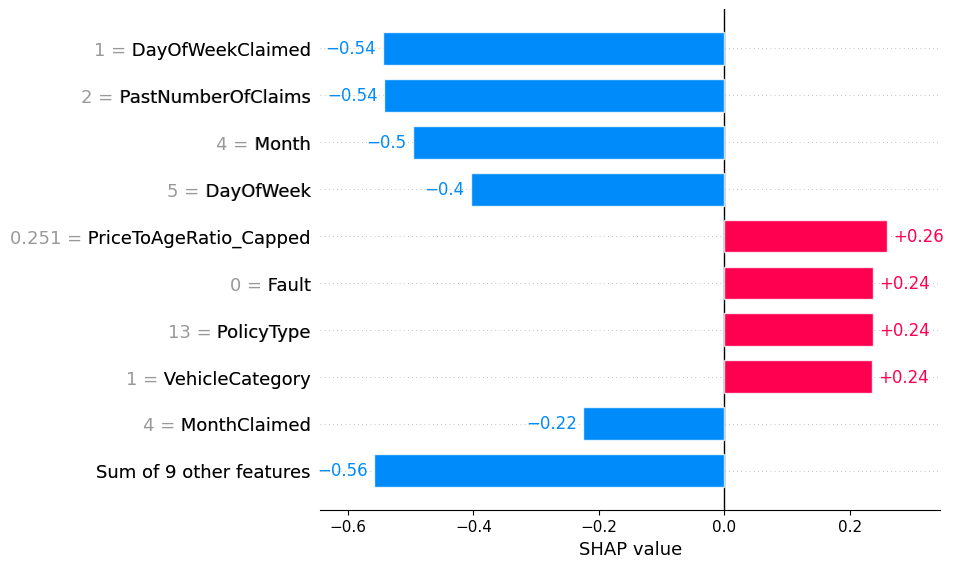

Base value: 3.162
Sum of SHAP values: -1.800
Predicted probability: 1.362


In [19]:
xgb_model = voting_clf.named_estimators_['xgb']
explainer = shap.TreeExplainer(xgb_model)
sample = X_test.iloc[[42]]

y_proba_sample = xgb_model.predict_proba(sample)[:, 1][0]
y_pred_sample = int(y_proba_sample >= best_threshold)

shap_values = explainer.shap_values(sample)
shap.plots.bar(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=sample.values[0], feature_names=sample.columns.tolist()))

print(f"Base value: {explainer.expected_value:.3f}")
print(f"Sum of SHAP values: {np.sum(shap_values[0]):.3f}")
print(f"Predicted probability: {explainer.expected_value + np.sum(shap_values[0]):.3f}")

### Undersampling

With a combined of around 15000 fraud and non-fraud cases, undersampling would reduce a significant amount of data (13000 cases), which can lead to loss of important information from the majority class that potentially holds valuable patterns that can help the model generalize better.

For fraud detection, it is typically better to use techniques that preserve data while addressing class imbalance hence we shall not proceed in depth with undersampled data.

In [ ]:
# Assuming numeric_df is your dataset (already loaded)
# Prepare the data
X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)

# Apply RandomUnderSampler to the training data to reduce the majority class size
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_train_under).value_counts())

# Train and evaluate a RandomForest model on the original dataset (without undersampling)
clf_original = RandomForestClassifier(random_state=42)
clf_original.fit(X_train, y_train)
y_pred_original = clf_original.predict(X_test)

# Train and evaluate a RandomForest model on the undersampled dataset
clf_under = RandomForestClassifier(random_state=42)
clf_under.fit(X_train_under, y_train_under)
y_pred_under = clf_under.predict(X_test)

print("\nPerformance on undersampled dataset:")
print(classification_report(y_test, y_pred_under, zero_division=0))

Class distribution after undersampling:
FraudFound_P
0    724
1    724
Name: count, dtype: int64

Performance on undersampled dataset:
              precision    recall  f1-score   support

           0       0.99      0.65      0.78      2885
           1       0.15      0.87      0.25       199

    accuracy                           0.66      3084
   macro avg       0.57      0.76      0.51      3084
weighted avg       0.93      0.66      0.75      3084



From the result above, we can see that the precision and f1-score of the undersampled data is very low. While the model has high recall, it is returning many false positives as its precision is not there. Thus, it shows that the model is just classfying everything as fraud as it does not have have enough data to learn from.